In [1]:
import sys
if sys.version_info[0] < 3:
    print(sys.version_info)
    raise Exception("Must be using Python 3")
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import scraper
import pickle
from pprint import pprint

In [2]:
def priceChanges(prices):
    absChange = [0]*(len(prices)-1)
    percChange = [0]*(len(prices)-1)
    for i in range(0,len(prices)-1):
        absChange[i] = prices[i+1]-prices[i]
        percChange[i] = absChange[i]/prices[i]
    return absChange,percChange

def marginChanges(prices,buylimit):
    absChange = [0]*(len(prices)-1)
    percChange = [0]*(len(prices)-1)
    for i in range(0,len(prices)-1):
        absChange[i] = prices[i+1]*buylimit-prices[i]*buylimit
        percChange[i] = absChange[i]/(prices[i]*buylimit)
    return absChange,percChange

In [3]:
itemInfo = scraper.loadItemInfo()

In [4]:
#col 13 = exchangePrice
natPrice = scraper.getExchangeInfo('Nature_rune')['price']
profits = []
for item in itemInfo:
    try:
        #print(int(item['exchangePrice'])+natPrice,int(item['highAlch']))
        exPrice = int(item['exchangePrice'])
        alchPrice = int(item['highAlch'])
        if exPrice!=-1 and exPrice+natPrice < alchPrice:
            #print(item)
            buyLimit = int(item['buyLimit'])
            profits.append((item,alchPrice/(exPrice+natPrice)))
    except ValueError:
        pass
def getKey(item):
    return item[1]
profits.sort(key=getKey,reverse=True)
#pprint(profits[:10])

In [5]:
itemPrices = scraper.loadItemPrices()

In [6]:
# check length of available datasets
sizes = {}
for item in itemPrices:
    l = len(itemPrices[item])
    if l in sizes:
        sizes[l]+=1
    else:
        sizes[l] = 1
cumSum = 0
cumSums = []
keys = []
for key in sorted(sizes,reverse=True):
    print("%s: %s" % (key, sizes[key]))
    keys.append(key)
    cumSum += sizes[key]
    cumSums.append(cumSum)
cumSums = np.array(cumSums)/cumSum

1336: 2
1329: 256
1328: 509
1327: 34
1307: 1925
1306: 94
1231: 62
1230: 3
1113: 5
1112: 1
1020: 6
1019: 25
1018: 1
1003: 1
969: 1
896: 1
895: 19
894: 11
888: 9
887: 1
873: 2
872: 2
866: 2
853: 1
838: 1
833: 1
832: 61
831: 20
830: 6
829: 1
819: 6
807: 1
801: 1
755: 1
752: 1
748: 2
747: 4
732: 1
724: 1
701: 1
648: 3
647: 18
646: 20
645: 14
644: 9
643: 1
637: 3
634: 1
627: 1
623: 2
621: 24
620: 1
613: 1
592: 1
553: 1
530: 1
499: 3
498: 1
486: 13
458: 1
411: 6
410: 15
409: 3
363: 5
361: 1
355: 1
334: 5
332: 2
318: 1
292: 1
291: 8
290: 26
289: 6
288: 10
275: 3
274: 1
273: 1
272: 1
269: 9
264: 2
263: 1
262: 2
261: 2
260: 3
258: 5
254: 2
253: 1
174: 2
151: 1
137: 18
101: 1
86: 3
85: 1
43: 7
42: 3
41: 2
0: 28


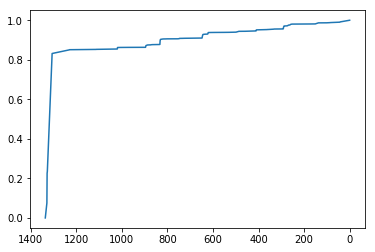

In [7]:
# probably 1306
plt.plot(keys,cumSums)
plt.gca().invert_xaxis()

In [9]:
toRemove = []
for item in itemPrices:
    if len(itemPrices[item])<1306:
        toRemove.append(item)
for item in toRemove:
    itemPrices.pop(item)

In [10]:
def reject_outliers(data):
    top = np.quantile(data,.75)
    bottom = np.quantile(data,.25)
    IQR = top-bottom
    return [d for d in data if d>bottom-1.5*IQR and d<top+1.5*IQR]

def calculateCOV(arr):
    prices = [p[1] for p in arr[-100:]]
    #print(stats.variation(prices))
    prices = reject_outliers(prices)
    return stats.variation(prices)

In [12]:
print(calculateCOV(itemPrices['Abyssal_whip']))

0.05072412106110289


In [13]:
priceVariances = []
for item in itemPrices:
    priceVariances.append((calculateCOV(itemPrices[item]),item))

def getKey(item):
    return item[0]

priceVariances.sort(key=getKey,reverse=True)

/home/makoa/.local/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/makoa/.local/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/makoa/.local/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/makoa/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1025: RuntimeWarning: Mean of empty slice.
  return a.std(axis) / a.mean(axis)
/home/makoa/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
pprint(priceVariances[:10])

[(0.5254065096944085, 'Body_tiara'),
 (0.511078730168917, 'Tarromin_seed'),
 (0.4581201797373859, 'Mithril_platebody_(t)'),
 (0.422079668671321, 'Empty_fishbowl'),
 (0.39531818870755325, 'Apple_tree_seed'),
 (nan, 'Pure_essence'),
 (0.6241358138216521, 'Bronze_battleaxe'),
 (0.3901545583714563, 'Adamant_full_helm_(t)'),
 (0.36107761325143556, 'Ancient_platebody'),
 (0.35613921470579846, 'Maple_shortbow_(u)')]


In [15]:
def bollingerBands(data):
    means = []
    stds = []
    for i in range(20,len(data)):
        d = data[i-20:i]
        means.append(np.mean(d))
        stds.append(np.std(d))
    return np.array(means),np.array(stds)

def plotBollingerBands(data,means,stds):
    plt.figure(figsize=(20,10))
    plt.plot(means+2*stds,'r-')
    plt.plot(means+(-2*stds),'r-')
    plt.plot(means,'g--')
    plt.plot(data[20:],'b-')
    plt.show()
    

In [16]:
itemPrices = scraper.loadItemPrices()

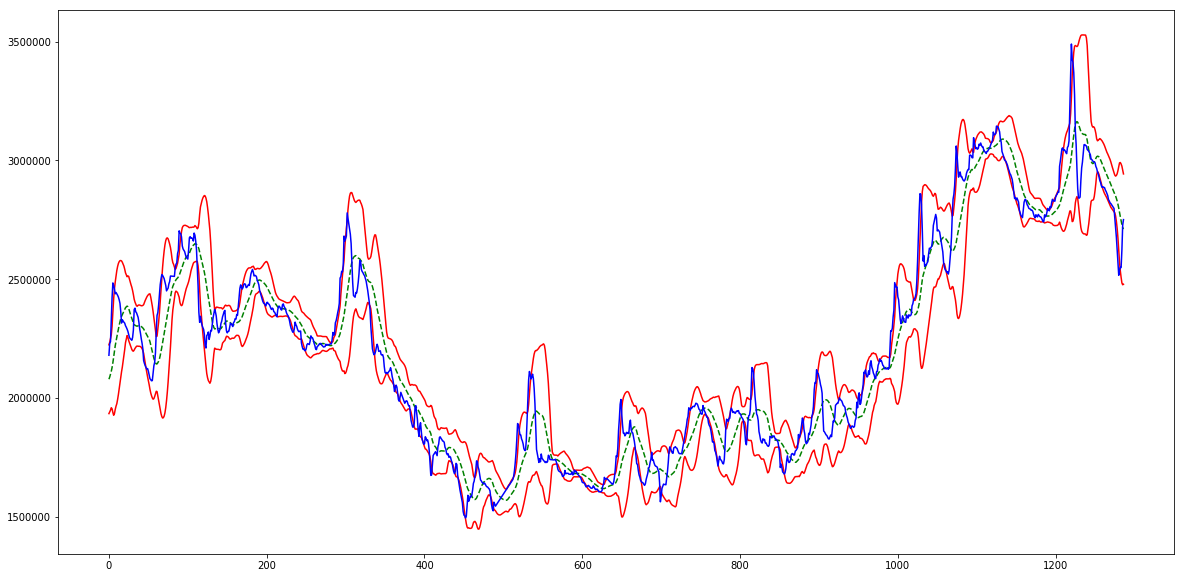

0.6668484384327202


In [17]:
prices = [a[1] for a in itemPrices['Abyssal_whip']]
means,stds = bollingerBands(prices)
plotBollingerBands(prices,means,stds)
print(np.std(stds)/np.mean(stds))

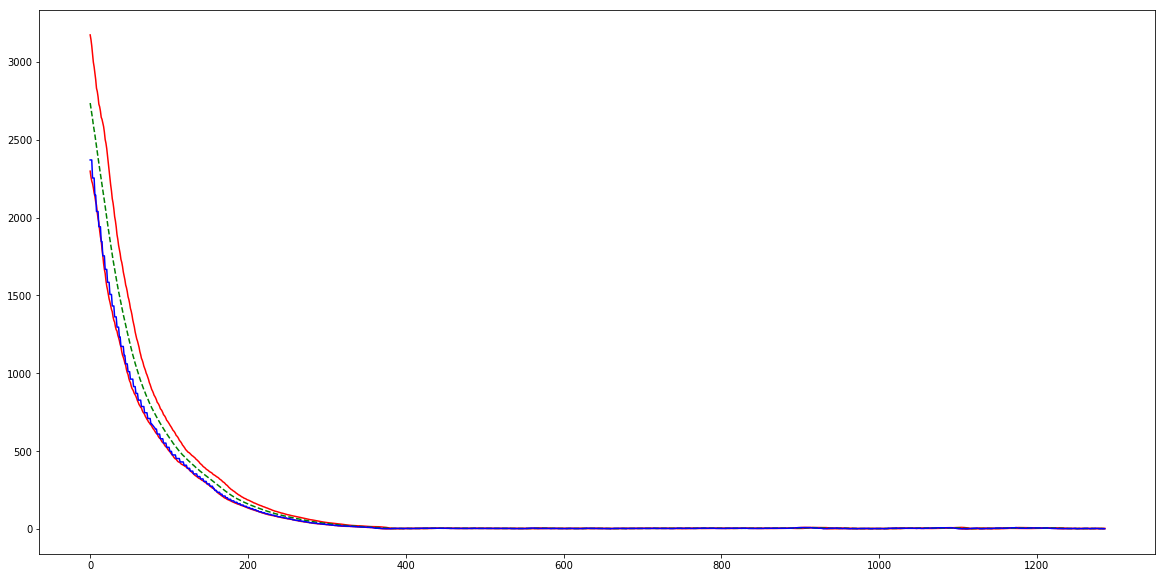

2.9139271068088517


In [18]:
prices = [a[1] for a in itemPrices['Body_tiara']]
means,stds = bollingerBands(prices)
plotBollingerBands(prices,means,stds)
print(np.std(stds)/np.mean(stds))

In [ ]:
def getPerfectProfit(data):
    buyers = [10**5,10**6,10**7,10**8,10**9,10**10]
    profit = [0] * len(buyers)
    count = [0] * len(buyers)
    for i in range(1,len(data)):
        if data[i]>data[i-1]:
            for b in range(len(buyers)):
                amount = int(buyers[b]/data[i-1])
                profit[b] += (data[i]-data[i-1])*amount
                count[b] += amount
    for b in range(len(buyers)):
        if count[b] == 0:
            profit[b] == 0
        else:
            profit[b]/=count[b]
    return profit

In [ ]:
itemInfo = scraper.loadItemInfo()
itemPrices = scraper.loadItemPrices()

for item in itemPrices:
    prices = [a[1] for a in itemPrices[item]]
    mean = np.mean(prices)
    std = np.std(prices)
    itemPrices[item] = [itemPrices[item][i] for i in range(len(prices)) if prices[i]>mean+2*std]

In [ ]:
profits = []
for item in itemPrices:
    profits.append((getPerfectProfit([a[1] for a in itemPrices[item]]),item))

def getKey(item):
    return item[0][1]

profits.sort(key=getKey,reverse=True)